In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



#Heart Indicators

#Relevancia de las enfermedades cardíacas
Según la CDC (Center of Disease Control), las enfermedades cardíacas son una de las principales causas de muerte para las personas de la mayoría de las razas en los EE. UU. (afroamericanos, indios americanos y nativos de Alaska, y blancos). Aproximadamente la mitad de todos los estadounidenses (47 %) tienen al menos 1 de 3 factores de riesgo clave de enfermedad cardíaca: presión arterial alta, colesterol alto y tabaquismo. Otros indicadores clave incluyen el estado diabético, la obesidad (IMC alto), no realizar suficiente actividad física o beber demasiado alcohol. Esta problemática se presenta de forma similar en los demás países del mundo y es característica del modo de vida sedentario que llevamos en las sociedades modernas. Detectar y prevenir los factores que más inciden en las enfermedades del corazón es muy importante en el ámbito sanitario debido a que los tratamientos disponibles ejercen su efecto sobre los síntomas dado que las causas son conductuales. Los desarrollos computacionales, a su vez, permiten la aplicación de métodos de aprendizaje automático para detectar "patrones" a partir de los datos que pueden predecir la condición de un paciente y corregir sus hábitos antes de que se presenten mayores dificultades.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Origen de los datos usados en este trabajo
Originalmente, el conjunto de datos proviene del Sistema de Vigilancia de Factores de Riesgo del Comportamiento (BRFSS), que realiza encuestas telefónicas anuales para recopilar datos sobre el estado de salud de los residentes de EE. UU desde 1984.

https://www.cdc.gov/brfss/annual_data/annual_data.htm

El conjunto de datos más reciente (al 15 de febrero de 2022) incluye datos de 2020. Consta de 401.958 filas y 279 columnas. La gran mayoría de las columnas son preguntas que se hacen a los encuestados sobre su estado de salud, como "¿Tiene serias dificultades para caminar o subir escaleras?" o "¿Has fumado al menos 100 cigarrillos en toda tu vida?". Sobre este conjunto original nosotros tomamos una selección disponible en la plataforma Kaggle:

https://www.kaggle.com/code/mushfirat/heartdisease-eda-prediction/notebook

A diferencia del conjunto de datos de la BRFSS solo contiene 20 columnas con los factores de mayor relevancia según el curador de esta selección. Viendo los resultados obtenidos por el autor pensamos que podría refinarse su modelo para mejorar las métricas de calidad obtenidas por el mismo. Es interesante destacar que se desarrolló una app que permite interactuar con el modelo de forma amigable y que en caso de poder mejorarlo sería posible implementar una interface similar con el nuevo modelo:

https://share.streamlit.io/kamilpytlak/heart-condition-checker/main/app.py

In [ ]:
# Importamos e instalamos las librerías a utilizar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
!pip install dython
from dython.nominal import associations
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import time
import lightgbm as lgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Definimos los parametros de los graficos de seaborn
custom_params = {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': False, 'axes.spines.left': False, 'axes.labelsize': 12, 'figure.figsize' : (15,6)}
sns.palette='Blues_d'


In [ ]:
# Definimos las paletas de colores a utilizar
BluesGreys = ['rgb(96, 150, 186)', 'rgb(107, 108, 105)', 'rgb(39, 76, 119)', 'rgb(163, 206, 241)', 'rgb(65, 66, 64)']

In [ ]:
# Llamamos al data set a utilizar, lo presentamos como data frame y visualizamos los primeros 10 registros para tener una idea general de su contenido
df_or=pd.read_csv('/content/drive/MyDrive/Data Coder - Trabajo final/PRE ENTREGA GRUPO 3/Data Set Heart Indicators.csv')
#df_or=pd.read_csv("/content/drive/MyDrive/coderhouse/Data science/TP final/Data Set Heart Indicators.csv")


In [ ]:
#Debido al gran tamaño del data set decidimos tomar una muestra para poder trabajar apropiadamente.
df_or = df_or.sample(n=4000, random_state=123)
df_or.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
13706,No,37.76,Yes,No,No,0,0,No,Female,65-69,White,No,Yes,Good,6,No,No,No
39766,No,37.31,No,No,No,3,0,No,Female,35-39,Black,No,No,Very good,6,Yes,No,No
69898,No,23.83,No,No,No,10,23,No,Female,18-24,White,No,Yes,Very good,6,Yes,No,No
21469,No,24.19,No,No,No,0,0,No,Female,50-54,Hispanic,Yes,Yes,Fair,6,No,No,No
184046,No,27.32,Yes,No,No,0,0,No,Male,60-64,White,No,No,Good,7,No,No,No


#Análisis Explotario de los Datos

In [ ]:
# Visualizamos la información general del data set para conocer los datos y sus tipos como así también si tenemos campos nulos
df_or.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 13706 to 118707
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      4000 non-null   object 
 1   BMI               4000 non-null   float64
 2   Smoking           4000 non-null   object 
 3   AlcoholDrinking   4000 non-null   object 
 4   Stroke            4000 non-null   object 
 5   PhysicalHealth    4000 non-null   int64  
 6   MentalHealth      4000 non-null   int64  
 7   DiffWalking       4000 non-null   object 
 8   Sex               4000 non-null   object 
 9   AgeCategory       4000 non-null   object 
 10  Race              4000 non-null   object 
 11  Diabetic          4000 non-null   object 
 12  PhysicalActivity  4000 non-null   object 
 13  GenHealth         4000 non-null   object 
 14  SleepTime         4000 non-null   int64  
 15  Asthma            4000 non-null   object 
 16  KidneyDisease     4000 non-null   ob

Como hemos comentado los datos surgen de una encuesta del CDC así que muchas de las variables se define en funcion de las preguntas realzadas. La primera de ellas es nuestra variable objetivo HeartDisease


*   'HeartDisease' : encuestados que alguna vez informaron haber tenido una enfermedad cardíaca coronaria o un infarto de miocardio.
*'BMI': Índice de Masa Corporal (IMC).
*'Smoking' : ¿Ha fumado al menos 100 cigarrillos en toda su vida?
*'AlcoholDrinking' : grandes bebedores (hombres adultos que toman más de 14 tragos por semana y mujeres adultas que toman más de 7 tragos por semana)
*'Stroke' : (Alguna vez le dijeron) (usted tuvo) un accidente cerebrovascular?
*'PhysicalHealth' : ahora pensando en su salud física, que incluye enfermedades y lesiones físicas, ¿durante cuántos días durante los últimos 30 días su salud física no fue buena? (0-30 días).
*'MentalHealth' : Pensando en su salud mental, ¿durante cuántos días durante los últimos 30 días su salud mental no fue buena? (0-30 días).
*'DiffWalking' : ¿Tiene serias dificultades para caminar o subir escaleras?
*'Sex' : ¿Eres hombre o mujer?
*'AgeCategory' : Categoría de edad de catorce niveles.
*'Race' : raza/etnicidad autopercibido
*'Diabetic' : (Alguna vez le dijeron) (usted tenía) diabetes?
*'PhysicalActivity' : adultos que informaron haber realizado actividad física o ejercicio durante los últimos 30 días además de su trabajo habitual.
*'GenHealth' : ¿Diría usted que, en general, su salud es...
*'SleepTime' : En promedio, ¿cuántas horas duermes en un período de 24 horas?
*'Asthma' : (Alguna vez dijo) (usted tenía) asma?
*'KidneyDisease' : sin incluir cálculos renales, infección de la vejiga o incontinencia, ¿alguna vez le dijeron que tenía una enfermedad renal?
*'SkinCancer' : (Alguna vez le dijeron) (usted tenía) cáncer de piel?


#Análisis Univariado

##Variables Cuantitativas

In [ ]:
# Sabemos el tipo de datos reflejado en la información anterior que existen 4 variables numéricas por lo que hacemos una descripción de los mismos
round(df_or.describe(),2)

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,4000.00,4000.00,4000.00,4000.00
mean,28.14,3.36,3.96,7.07
std,6.20,7.96,7.97,1.43
min,12.44,0.00,0.00,1.00
25%,23.91,0.00,0.00,6.00
50%,27.20,0.00,0.00,7.00
75%,31.28,2.00,3.00,8.00
max,75.28,30.00,30.00,20.00


In [ ]:
# Evaluamos la variable Sleep Time individualmente a través de un gráfico BoxPlot
px.box(df_or, x='SleepTime', title='Análisis del tiempo de sueño', width=1000, height=300)

El 50% de las personas encuestadas duerme entre 6 y 8 horas, lo que era de esperarse teniendo en cuenta el ritmo circadiano normal. A pesar de esto la otra mitad de la muestra se encuentra por fuera de estos límites llegando a dormir 3 horas como mínimo y 11 horas como máximo. Siendo una enfermedad poco frencuente los valores fueras de la norma pueden ser valiosos para encontrar correlaciones con nuestro target.

In [ ]:
# Evaluamos la variable Sleep Time individualmente a través de un gráfico BoxPlot
px.box(df_or, x='BMI', title='Análisis del Índice de Masa Corporal', width=1000, height=300)

Según el NHS de estados únidos las categorias determinadas por el indice de masa corporal: Si su IMC es:

* "por debajo de 18,5" : estás en el rango de bajo peso
*"entre 18,5 y 24,9" : estás en el rango de peso saludable
*"entre 25 y 29,9" : estás en el rango de sobrepeso
*"entre 30 y 39,9" : estás en el rango de obesidad

Viendo nuestro gráfico encontramos que cada cuartil representa uno de estos rangos. Esto se puede indicar que el criterio de con el que se determinaron estos rangos fue precisamente la determinación de los cuartiles de una población general.

In [ ]:
# Evaluamos la variable BMI individualmente a través de un gráfico combinado 
hist_data = [df_or['BMI']]
group_labels = ['BMI'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Análisis del Índice de Masa Corporal - Gráfico Combinado', width=1000, height=300)
fig.show()

In [ ]:
hist_data = [df_or['MentalHealth']]
group_labels = ['MentalHealth'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Análisis de la percepción propia de Salud Mental',width=1000, height=300)
fig.show()

Considerando el gráfico anterior se puede ver que la gran mayoria de la muestra tiene una baja frecuencia de problemas relaciandos a su estado de salud mental

In [ ]:
hist_data = [df_or['PhysicalHealth']]
group_labels = ['PhysicalHealth'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Análisis de la percepción propia de Salud Física',width=1000, height=300)
fig.show()

Lo mismo se puede decir con respecto a la salud física de las persona, la mayoria de las personas solo reportan uno o dos días con dificultades de salud en el último mes

In [ ]:
df_or_ac = df_or['AgeCategory'].value_counts().sort_index().to_frame().reset_index()
df_or_ac

,index,AgeCategory
0,18-24,251
1,25-29,218
2,30-34,222
3,35-39,274
4,40-44,278
5,45-49,270
6,50-54,311
7,55-59,335
8,60-64,433
9,65-69,448


Text(0.5, 1.0, 'Análisis de los Grupos de Rango Etario')

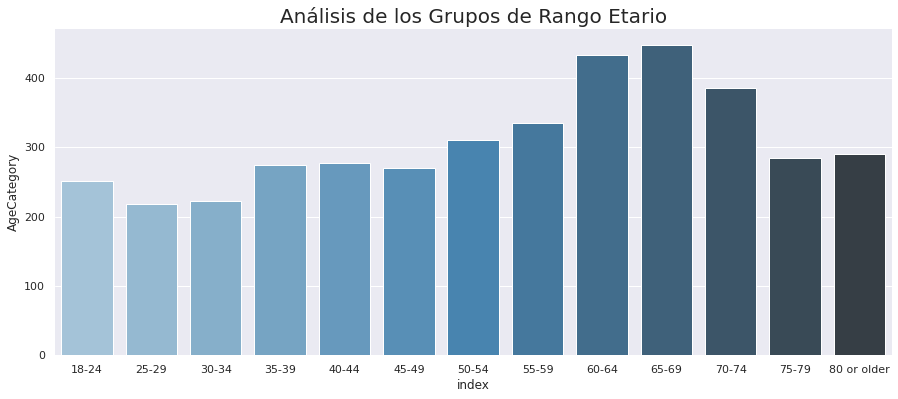

In [ ]:
sns.set_theme(rc=custom_params)
sns.barplot(x='index', y='AgeCategory', data=df_or_ac, palette='Blues_d').set_title('Análisis de los Grupos de Rango Etario', fontdict = { 'fontsize': 20})

La distribución de edades en las personas encuestadas es bastante pareja aunque se ve una preferencia por informantes cercanos a los 50, talvez porque el formato de la encuesta es telefónica. Se podria atraer a las nuevas generaciones por un formulario virtual y más aún si esta acoplado a una red social (encuesta de Instagram)

##Variables Cualitativas

In [ ]:
df_or_gh = df_or['GenHealth'].value_counts().sort_index().to_frame().reset_index()
df_or_gh

,index,GenHealth
0,Excellent,835
1,Fair,423
2,Good,1179
3,Poor,143
4,Very good,1420


Text(0.5, 1.0, 'Análisis de los Grupos Estado de Salud')

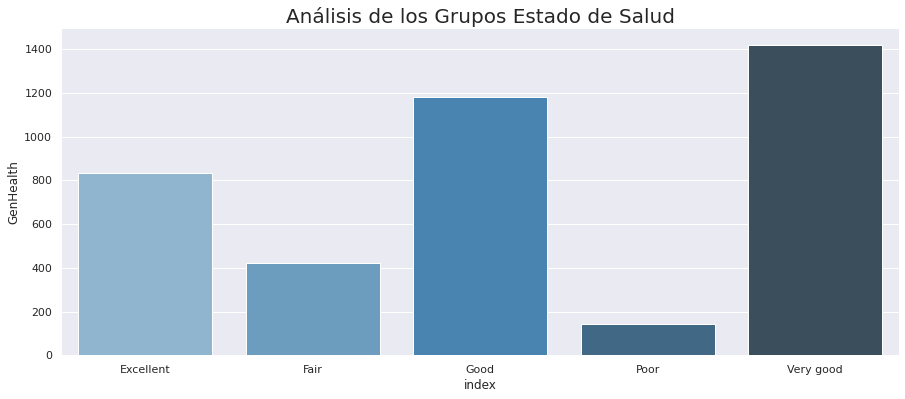

In [ ]:
sns.set_theme(rc=custom_params)
sns.barplot(x='index', y='GenHealth', data=df_or_gh, palette='Blues_d').set_title('Análisis de los Grupos Estado de Salud', fontdict = { 'fontsize': 20})

Este gráfico expresa de forma más compacta la autopercepción del estado de salud de las personas que los segregados por salud mental y física. Son mucho menores los casos que consideran su salud de mala o justa que los casos de personas que la consideran muy buena e incluso excelente.

In [ ]:
df_or_r = df_or['Race'].value_counts().sort_index().to_frame().reset_index()
df_or_r

,index,Race
0,American Indian/Alaskan Native,57
1,Asian,100
2,Black,296
3,Hispanic,330
4,Other,150
5,White,3067


Text(0.5, 1.0, 'Análisis de los Grupos Étnicos ')

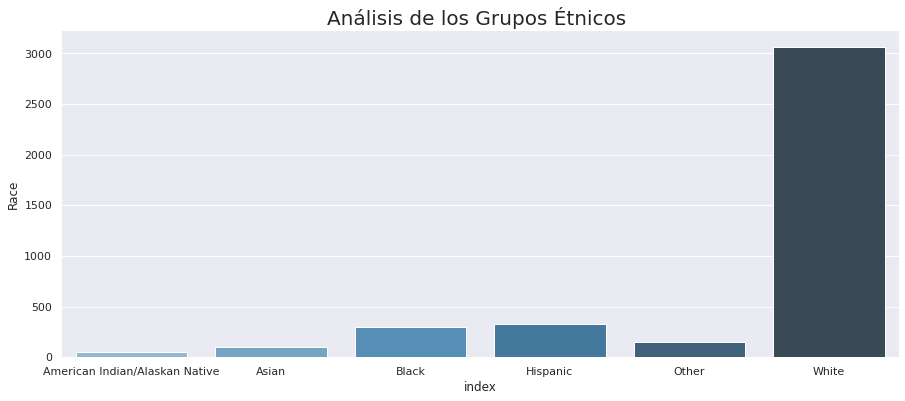

In [ ]:
sns.set_theme(rc=custom_params)
sns.barplot(x='index', y='Race', data=df_or_r, palette='Blues_d').set_title('Análisis de los Grupos Étnicos ', fontdict = { 'fontsize': 20})

El predominio de personas blancas dentro de la muestra indica la distribuciòn étnica del país donde se tomaron los datos (USA). Esta información sería relevante al querer aplicar el modelo obtenido con estos, sobretodo si se encuentra que esta variable tiene una alta correlación con nuestra variable target

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_or['Smoking'].unique(), values=df_or['Smoking'].value_counts(), name='Smoking', marker_colors = BluesGreys),
              1, 1)
fig.add_trace(go.Pie(labels=df_or['AlcoholDrinking'].unique(), values=df_or['AlcoholDrinking'].value_counts(), name='AlcoholDrinking'),
              1, 2)
fig.update_traces(hole=.5)
fig.update_layout(
    title_text='Análisis de Hábitos no saludables', font_size=18,
    annotations=[dict(text='Fumadores', x=0.18, y=1.3, font_size=12, showarrow=False),
                 dict(text='Bebedores de alcohol', x=0.87, y=1.3, font_size=12, showarrow=False)], width=1000, height=300)
fig.show()

Aunque se puede ver a primera vista que la cantidad de fumadores es mucho mayor que la de bebedores hay que recordar que para la primer categoria se considera a las personas que hayan fumado al menos 100 cigarrillos y para el caso del alcohol es necesario en promedio uno o dos tragos por dia. Una persona que toma dos o tres tragos el fin de semana no entraria en la categoria de "AlcoholDrinking"

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_or['Asthma'].unique(), values=df_or['Asthma'].value_counts(), name='Asthma', marker_colors = BluesGreys),
              1, 1)
fig.add_trace(go.Pie(labels=df_or['KidneyDisease'].unique(), values=df_or['KidneyDisease'].value_counts(), name='KidneyDisease'),
              1, 2)
fig.add_trace(go.Pie(labels=df_or['SkinCancer'].unique(), values=df_or['SkinCancer'].value_counts(), name='SkinCancer'),
              1, 3)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.5)

fig.update_layout(
    title_text='Análisis de Otras Enfermedades', font_size=18,
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Asthma', x=0.10, y=1.3, font_size=12, showarrow=False),
                 dict(text='KidneyDisease', x=0.50, y=1.3, font_size=12, showarrow=False),
                 dict(text='SkinCancer', x=0.90, y=1.3, font_size=12, showarrow=False)],width=1000, height=300)
fig.show()

In [ ]:
df_or_sc = df_or['SkinCancer'].value_counts().sort_index().to_frame().reset_index()
df_or_sc

,index,SkinCancer
0,No,3615
1,Yes,385


In [ ]:
df_or_a = df_or['Asthma'].value_counts().sort_index().to_frame().reset_index()
df_or_a

,index,Asthma
0,No,3478
1,Yes,522


Se puede ver que la prevalencia de estas enfermedades en la poblacion es de alrededor del un 10%

#Análisis Bivariado

𝜙k
Los diferenciadores clave de Phik son:

se basa en varios refinamientos del χ2 de Pearson (chi-cuadrado) prueba de contingencia: una prueba de hipótesis para la independencia entre dos (o más) variables,

funciona consistentemente entre variables categóricas, ordinales y de intervalo (continuas),

captura dependencias no lineales,

revierte al coeficiente de correlación de Pearson en el caso de una distribución normal bivariada de la entrada, el algoritmo contiene una técnica de reducción de ruido integrada frente a las fluctuaciones estadísticas.

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [ ]:
interval_cols = ['PhysicalHealth', 'MentalHealtk','BMI']
phik_overview = df_or.phik_matrix(interval_cols=interval_cols).round(1)

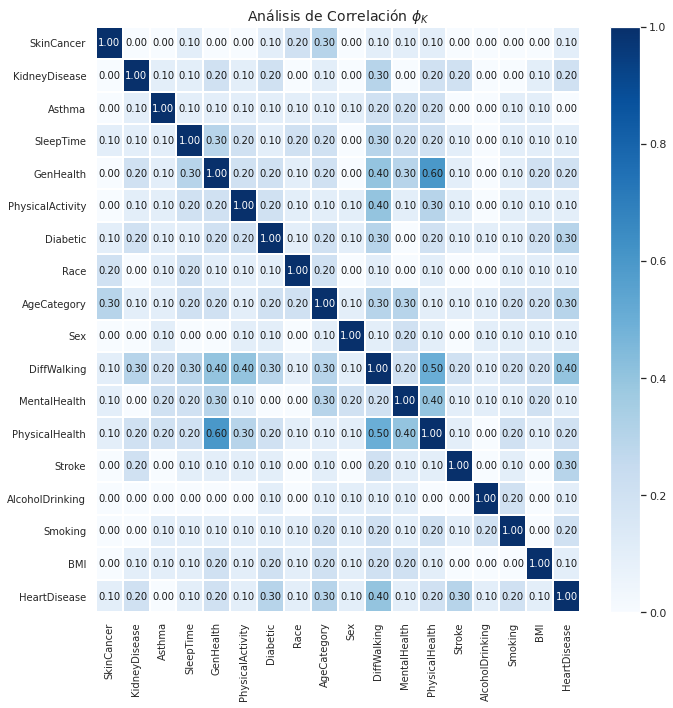

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title=r'Análisis de Correlación $\phi_K$', 
                        fontsize_factor=1, 
                        figsize=(10, 10))
plt.tight_layout()

De este paneo general se puede ver que hay una correlación considerable entre "PhycalHealth" y "GeneralHealth" pero no entre estas y "MentalHealth", lo que a primera instancia podria indicar que los encuestados valoran mas su salud fisica que mental al momento de evaluar su salud global. Por otro lado otra correlación significativa es entre la salud fisica y la tendencia a caminar, que era esperable. Algo que puede ser un poco desalentador es que ninguna de las variables tiene una correlación grande con la variable objetivo "HeartDisease"

Text(0.5, 1.0, 'Análisis de la realción Enfermedades cardiacas & Índice de Masa Corporal ')

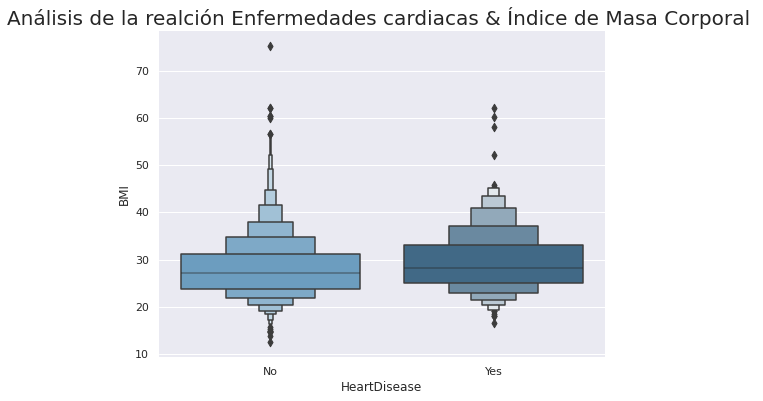

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxenplot(x=df_or['HeartDisease'], y=df_or['BMI'], palette='Blues_d').set_title('Análisis de la realción Enfermedades cardiacas & Índice de Masa Corporal ', fontdict = { 'fontsize': 20})

La distribucion de indice de masa corporal no parece diferir entre las personas 
entre el grupo con enfermedades cardiacas y el que no tiene.

Text(0.5, 1.0, 'Análisis de la realación de Enfermedades Cardiacas y Rango Etario ')

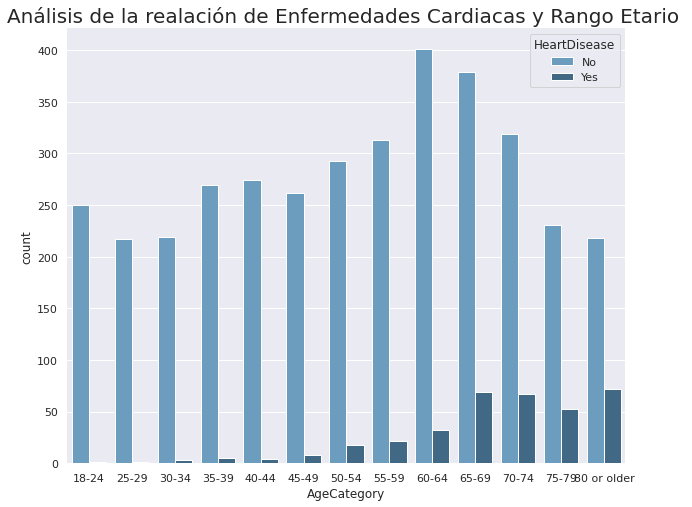

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(x='AgeCategory', hue='HeartDisease', data=df_or.sort_values('AgeCategory'), palette='Blues_d').set_title('Análisis de la realación de Enfermedades Cardiacas y Rango Etario ', fontdict = { 'fontsize': 20})

Las categorias de edad mas avanzada tiene mayor proporcion de personas con enfermedades cardiacas como era de esperarse.

#Análisis Multivariado

##Correlación

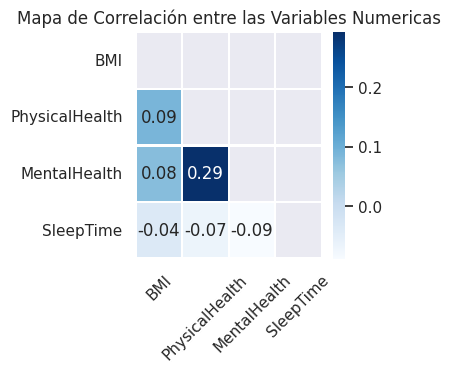

In [ ]:
#Generamos un grafico de correlacione entre las variables numéricas
sns.set_theme(rc=custom_params)
plt.figure(dpi = 100,figsize= (3,3))
mask = np.triu(np.ones_like(df_or.corr(),dtype = bool))
sns.heatmap(df_or.corr(),mask = mask, fmt = '.2f',annot=True,lw=1,cmap = 'Blues')
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
plt.title('Mapa de Correlación entre las Variables Numericas')
plt.show()

La correlacion entre las variables numerica es bastante baja, la mayor de ellas es entre los dos parametros de salud

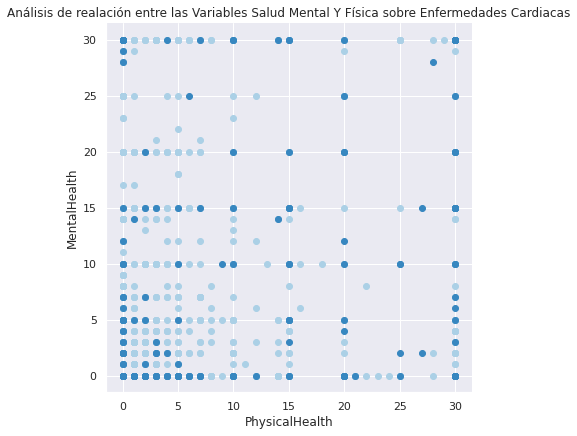

In [ ]:
#Representamos a través de un grafico FacetGrid la realción entre las variables de Salud Mental y Salud Fisica sobre la variable target Heart Disease.
sns.FacetGrid(df_or,hue = 'HeartDisease',height = 6,palette='Blues').map(plt.scatter,'PhysicalHealth','MentalHealth')
plt.title('Análisis de realación entre las Variables Salud Mental Y Física sobre Enfermedades Cardiacas')
plt.show()

Se puede ver que las personas con menor puntaje en los dos parametros de salud tienen mayor frecuencia de enfermedades cardiacas

##Asociación Cramer's V 

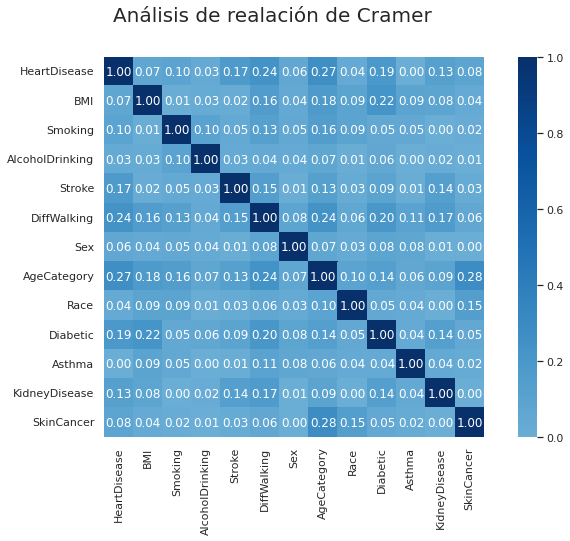

In [ ]:
# Representamos graficamente la asociación entre las variables a través de "Cramer's V association"
fig, ax = plt.subplots(figsize = (12, 7))
fig.suptitle('Análisis de realación de Cramer', fontsize=20)
cramers_v = associations(df_or[['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']], nom_nom_assoc = 'cramer', ax = ax, cmap = 'Blues')

#MODELOS

##Modelos de clasificacion 

In [ ]:
#Volvemos numericas las variables binarias
df_dum  = pd.get_dummies(df_or,drop_first=True)
df_dum.T.head(5)

,13706,39766,69898,21469,184046,55394,162651,158388,270454,114793,...,21950,250283,11331,5282,291142,294994,68062,171262,66273,118707
BMI,37.76,37.31,23.83,24.19,27.32,26.15,31.89,21.11,22.86,24.22,...,33.28,26.63,23.01,27.44,25.82,30.02,26.76,23.17,29.99,21.14
PhysicalHealth,0.00,3.00,10.00,0.00,0.00,10.00,0.00,0.00,2.00,0.00,...,0.00,2.00,0.00,0.00,0.00,21.00,7.00,0.00,0.00,0.00
MentalHealth,0.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,2.00,0.00,2.00,30.00,0.00,30.00
SleepTime,6.00,6.00,6.00,6.00,7.00,10.00,8.00,7.00,8.00,6.00,...,8.00,7.00,9.00,7.00,7.00,7.00,8.00,8.00,8.00,6.00
HeartDisease_Yes,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#Creo las variables para comenzar a buscar los modelos
X = df_dum.drop('HeartDisease_Yes', axis = 1)
y = df_dum['HeartDisease_Yes']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


##Modelo de regresión logistica

In [ ]:
logmodel = LogisticRegression( max_iter = 1000, random_state=123)

In [ ]:

logmodel.fit(X_train,y_train) 
score= cross_validate(logmodel, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression=pd.DataFrame(score)
pd.DataFrame(scoreregression.mean())

,0
fit_time,0.466319
score_time,0.021385
test_f1,0.192174
test_accuracy,0.895000
test_roc_auc,0.824501
test_recall,0.129167
test_precision,0.520238


##Bosque Aleatorio

In [ ]:

param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 200, 500]
}

RFC = RandomForestClassifier(class_weight={0: 0.1555855855855856, 1: 0.8444144144144143 })

grid_searchRF = GridSearchCV(estimator = RFC, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_searchRF.fit(X_train, y_train)
print(grid_searchRF.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [ ]:
print(grid_searchRF.best_params_)


{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [ ]:
RFC =RandomForestClassifier(bootstrap = True, max_depth=50, max_features= 2,
                            min_samples_leaf= 3, min_samples_split= 8, n_estimators= 100)
                            
RFC.fit(X_train,y_train) 
score= cross_validate(RFC, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scorereRFC=pd.DataFrame(score)
pd.DataFrame(scorereRFC.mean())

,0
fit_time,0.155558
score_time,0.033010
test_f1,0.000000
test_accuracy,0.902500
test_roc_auc,0.822515
test_recall,0.000000
test_precision,0.000000


##Modelo XGBoost


In [ ]:
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [50, 100]
        }

In [ ]:
xgb = XGBClassifier(class_weight={0: 0.1555855855855856, 1: 0.8444144144144143 })

#Armo la busqueda con GridSearch
gridsearch = GridSearchCV(estimator= xgb, 
                          param_grid= params,
                          cv=5, 
                          n_jobs=-1, 
                          scoring='roc_auc', 
                          verbose=2 ).fit(X_train, y_train)


print(gridsearch.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 50, 'min_child_weight': 5, 'subsample': 0.6}


In [ ]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=200,colsample_bytree= 0.6,
                    gamma= 0.5, max_depth= 50, min_child_weight= 5, subsample= 0.6
                    , objective='binary:logistic',
                    nthread=1)
xgb.fit(X_train,y_train)
                    

XGBClassifier(colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=50,
              min_child_weight=5, n_estimators=200, nthread=1, subsample=0.6)

In [ ]:
score= cross_validate(xgb, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression=pd.DataFrame(score)
pd.DataFrame(scoreregression.mean())

,0
fit_time,0.167880
score_time,0.008938
test_f1,0.000000
test_accuracy,0.901250
test_roc_auc,0.789194
test_recall,0.000000
test_precision,0.000000


##Adaboost

In [ ]:
ada = AdaBoostClassifier(n_estimators=500,learning_rate=0.01)

In [ ]:
start_time = time.time()
ada.fit(X_train,y_train) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.9234669208526611 seconds ---


In [ ]:
score= cross_validate(ada, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression=pd.DataFrame(score)
pd.DataFrame(scoreregression.mean())

,0
fit_time,0.946045
score_time,0.192434
test_f1,0.047059
test_accuracy,0.898750
test_roc_auc,0.803623
test_recall,0.026667
test_precision,0.200000


##LGBMC

In [ ]:
clf_lgbm = lgb.LGBMClassifier( n_estimators=500)

In [ ]:
start_time = time.time()
clf_lgbm.fit(X_train,y_train) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.578453779220581 seconds ---


In [ ]:
score= cross_validate(clf_lgbm, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression=pd.DataFrame(score)
pd.DataFrame(scoreregression.mean())

,0
fit_time,0.208055
score_time,0.022358
test_f1,0.262303
test_accuracy,0.888750
test_roc_auc,0.755098
test_recall,0.205000
test_precision,0.387302


##Mejor modelo

El modelo predictivo elegido es el de regresión logistica por tener la mayor AUC. En nuestro caso seria el modelo da bosques aleatorios.

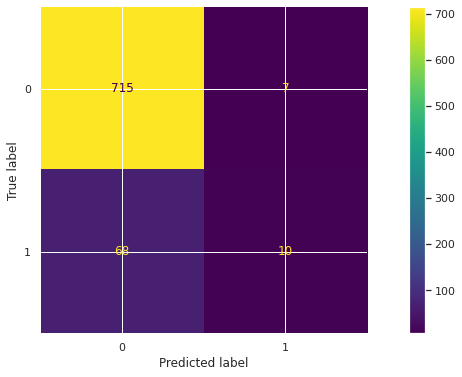

In [ ]:
plot_confusion_matrix(logmodel, X_test, y_test)  

Por medio de la matriz de confusión podemos ver que aún nuestro mejor modelo tiene dificultades para poder reconocer los errores de tipo 2 o falsos negativos.

## **Optimización del modelo**

Para tratar de mejorar nuestro modelo tomaremos dos caminos, primero probamoremos equilibrar las poblaciones usando el método de *oversampling* SMOTE y luego probaremos cambiar el peso de las clases para penalizar los errores de forma asimétrica

### **Con SMOTE**

Como el SMOTE introduce un sesgo que no esta en la población original termina teniendo un desempeño ligeramente menor que si no se usa


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

1    2923
0    2923
Name: HeartDisease_Yes, dtype: int64

El método de oversampling equilibra la proporción de cada categoría de la variable objetivo. Esta estrategia facilita el aprendizaje del modelo brindandole la misma cantidad de información sobre las variables dependientes tanto de los casos positivos como de los negativos

In [ ]:
# Buscamos el mejor balance de clases
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights],"C":np.logspace(-2,2,5)}




#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gridsearch .best_params_)
print("accuracy :",gridsearch.best_score_)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
tuned hpyerparameters :(best parameters)  {'C': 10.0, 'class_weight': {0: 0.495, 1: 0.505}}
accuracy : 0.8545655790009465


los weight optimos son simetricos  {0: 0.495, 1: 0.505} porque balanceamos el train set con SMOTE

In [ ]:
#Aumentamos el número de iteraciones a 1000 ya que con 100 no llegó a converger
logmodel = LogisticRegression(C= 10.0, class_weight = {0: 0.495, 1: 0.505}, penalty= 'l2',max_iter = 1000, random_state=123)

In [ ]:

logmodel.fit(X_train,y_train) 
score= cross_validate(logmodel, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression1=pd.DataFrame(score)
pd.DataFrame(scoreregression1.mean())

,0
fit_time,0.246966
score_time,0.010910
test_f1,0.285902
test_accuracy,0.898750
test_roc_auc,0.822495
test_recall,0.204167
test_precision,0.523810


<Figure size 288x288 with 0 Axes>

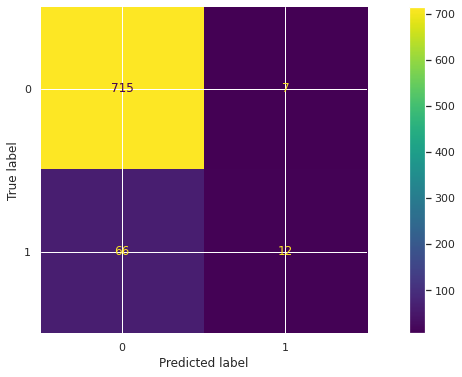

In [ ]:
plt.figure(figsize=(4, 4))
plot_confusion_matrix(logmodel, X_test, y_test) 


Para tener una idea de la eficacia del modelo para reconocer los falsos negativos se puede considerar el "false negative rate" o "miss rate" que se calcula como:

Falsos negativos/ Positivos totales

In [ ]:
threshold = 0.5
y_pred = (logmodel.predict_proba(X_test)[:, 1]<threshold).astype('float')
falsos_negativos = confusion_matrix(y_test, y_pred)[1][1]
positivos_verdaderos = confusion_matrix(y_test, y_pred)[1][0]
miss_rate = falsos_negativos/(falsos_negativos+positivos_verdaderos)
print("miss rate :" + str(miss_rate))
falsos_positivos = confusion_matrix(y_test, y_pred)[0][0]
negativos_verdaderos = confusion_matrix(y_test, y_pred)[0][1]
selectivity = falsos_positivos/(falsos_positivos+negativos_verdaderos)
print("selectivity :" + str(selectivity))

miss rate :0.8461538461538461
selectivity :0.009695290858725761


### **Sin SMOTE**

In [ ]:
#Separo en train y test
#from imblearn.over_sampling import SMOTE
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print(y_train.value_counts())
print("Propoción de muestras positivas en la muestra: " + str(y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1])))

0    2923
1     277
Name: HeartDisease_Yes, dtype: int64
Propoción de muestras positivas en la muestra: 0.0865625


Ahora solo una de cada personas en la muestra sufre una enfermedad cardíaca, por lo tanto el algorítmo tendra menos información sobre esta subpoblación en particular. La ventaja de quedarse con esta asimetría es que se puede conocer como penalizar a los errores del modelo para compensar este sezgo en la muestra.

In [ ]:
# Buscamos el mejor balance de clases
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights],"C":np.logspace(-2,2,5)}




#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gridsearch .best_params_)
print("accuracy :",gridsearch.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
tuned hpyerparameters :(best parameters)  {'C': 10.0, 'class_weight': {0: 0.2475, 1: 0.7525}}
accuracy : 0.35023099722426965


como el conjunto de datos esta desbalanceado los pesos 
óptimos son asimetricos {0: 0.2475, 1: 0.7525}.

In [ ]:
#Aumentamos el número de iteraciones a 10000 ya que con 100 no llegó a converger
logmodel = LogisticRegression( max_iter = 10000, random_state=0,class_weight= {0: 0.2475, 1: 0.7525}, penalty= 'l2', C = 100)

In [ ]:

logmodel.fit(X_train,y_train) 
score= cross_validate(logmodel, X_test, y_test, cv=5, scoring = ['f1','accuracy','roc_auc', 'recall','precision'])
scoreregression2=pd.DataFrame(score)
print("resultados de la muestra desbalanceada /n" + str(scoreregression2.mean()))
print("resultados de la muestra balanceada /n" + str(scoreregression1.mean()))

resultados de la muestra desbalanceada /nfit_time          0.560881
score_time        0.021015
test_f1           0.428044
test_accuracy     0.863750
test_roc_auc      0.818782
test_recall       0.528333
test_precision    0.366732
dtype: float64
resultados de la muestra balanceada /nfit_time          0.108854
score_time        0.010916
test_f1           0.177747
test_accuracy     0.895000
test_roc_auc      0.820804
test_recall       0.116667
test_precision    0.507143
dtype: float64


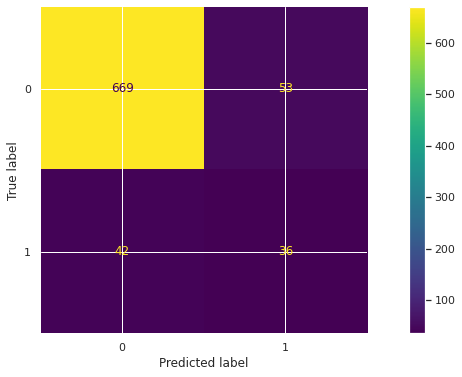

In [ ]:
plot_confusion_matrix(logmodel, X_test, y_test)  

In [ ]:
threshold = 0.5
y_pred = (logmodel.predict_proba(X_test)[:, 1]<threshold).astype('float')
falsos_negativos = confusion_matrix(y_test, y_pred)[1][1]
positivos_verdaderos = confusion_matrix(y_test, y_pred)[1][0]
miss_rate = falsos_negativos/(falsos_negativos+positivos_verdaderos)
print("miss rate :" + str(miss_rate))
falsos_positivos = confusion_matrix(y_test, y_pred)[0][0]
negativos_verdaderos = confusion_matrix(y_test, y_pred)[0][1]
selectivity = falsos_positivos/(falsos_positivos+negativos_verdaderos)
print("selectivity :" + str(selectivity))

miss rate :0.8461538461538461
selectivity :0.009695290858725761


Podemos ver que se puede llegar al mismo resultado tanto realizando un balance en la clase objetivo como asignando pesos asímetricos en el ajuste del modelo

Nuestro modelo reconoce diez veces mejor a las personas que tiene bajo riesgo que a las que tiene un riesgo alto. Teniendo en cuenta la gravedad de las enfermedades cardiacas comparada con el inconveniente de asistir a una consulta inecesaria decidimos bajar el umbral de clasificación de nuestro modelo

In [ ]:
threshold = 0.15
y_pred = (logmodel.predict_proba(X_test)[:, 1]<threshold).astype('float')
falsos_negativos = confusion_matrix(y_test, y_pred)[1][1]
positivos_verdaderos = confusion_matrix(y_test, y_pred)[1][0]
miss_rate = falsos_negativos/(falsos_negativos+positivos_verdaderos)
print("miss rate :" + str(miss_rate))
falsos_positivos = confusion_matrix(y_test, y_pred)[0][0]
negativos_verdaderos = confusion_matrix(y_test, y_pred)[0][1]
selectivity = falsos_positivos/(falsos_positivos+negativos_verdaderos)
print("selectivity :" + str(selectivity))

miss rate :0.11538461538461539
selectivity :0.3490304709141274


Cambiando el umbral de nuestro modelo podemos alcanzar una menor tasa de error a cambio de sacrificar parte de nuestra precisión. Sólo 1 de cada 8 personas de alto riesgo serán clasificadas equivocadamente, un error tres veces menor que en el caso de pacientes de bajo riesgo.